<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Amirhossein Akbari
### Student ID: 99105901

# Import necessary libraries

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [65]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Data Visualization

In [66]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

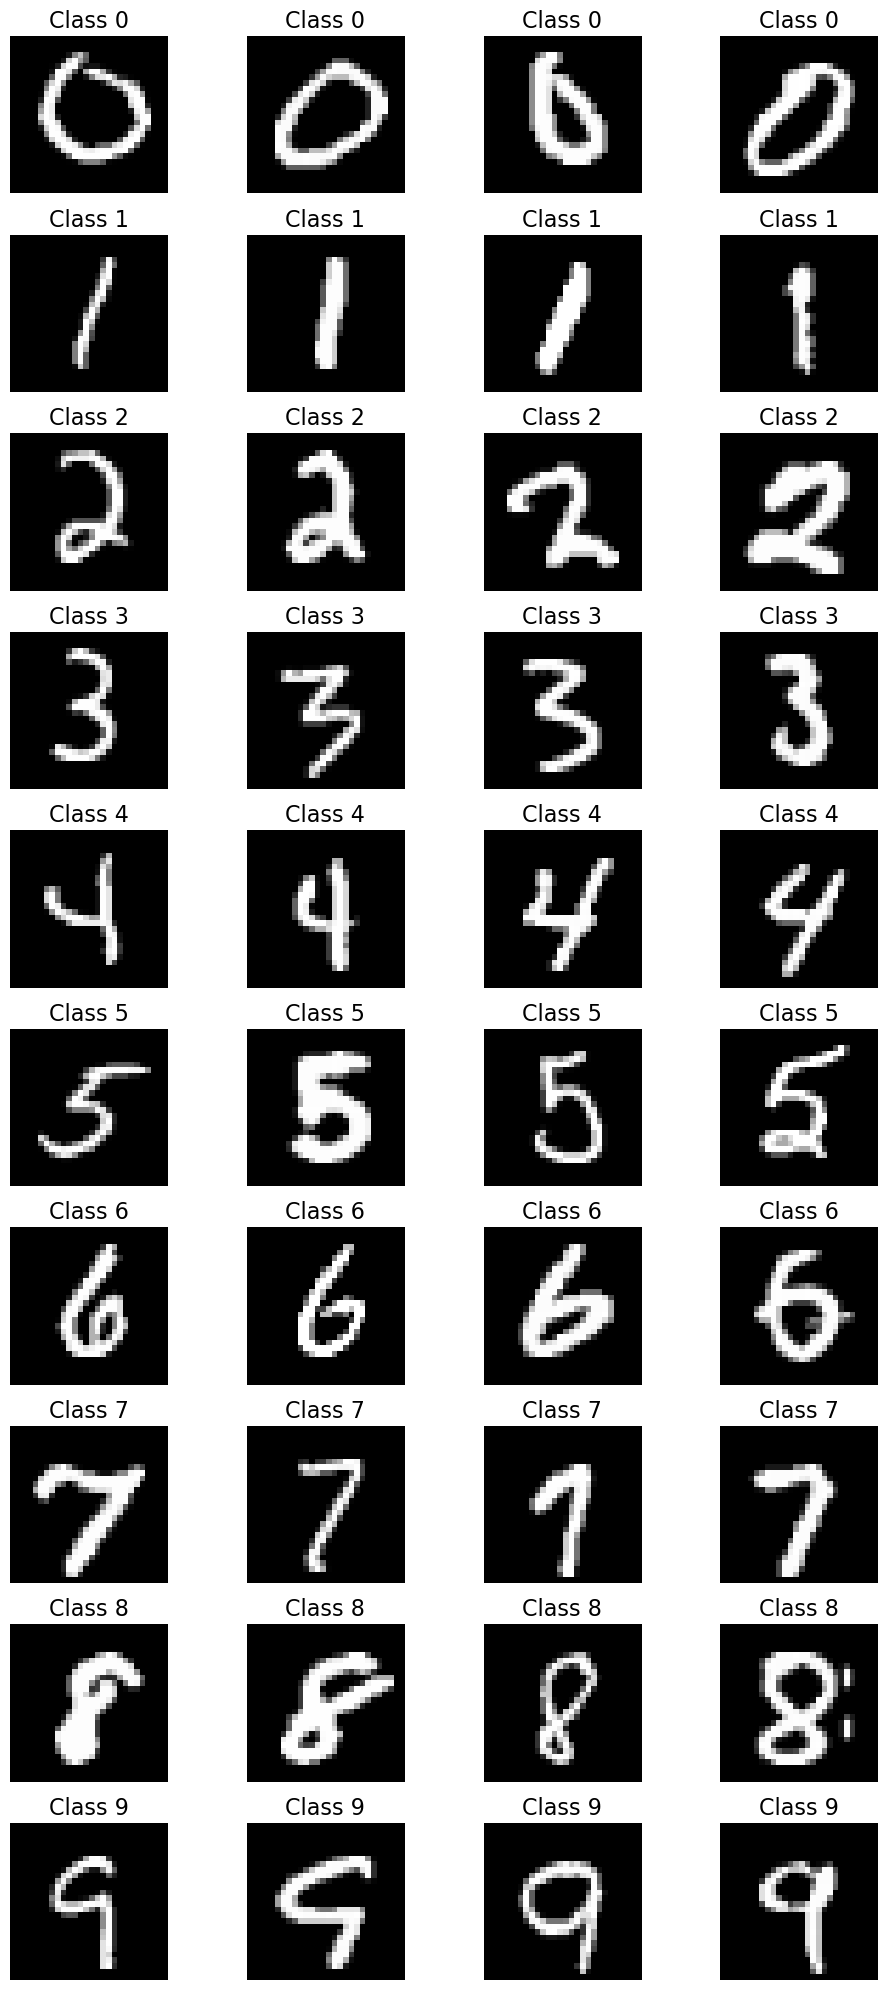

In [67]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [68]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU()
        )

        # Latent space layers
        self.fc_mu = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[2], latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()  # Sigmoid activation for the output to represent probabilities
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = x.view(-1, self.encoder[0].in_features)  # Flatten the input
        x = self.encoder(x)

        # Latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_reconstructed = self.decoder(z)

        return x_reconstructed, mu, logvar

In [69]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # Reconstruction Loss (binary cross-entropy for image data)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Loss (sum of reconstruction and KL divergence losses)
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [70]:
# # Training Loop - VAE (MLP)

def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3, latent_dim=2):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        
        if (100 * (epoch+1) / num_epochs) % 20 == 0:
            print()
            print(50 * "#")

        total_loss = 0
        for _, (data, _) in enumerate(train_loader):

            data = data.to(device)
            # Forward process
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        if (100 * (epoch+1) / num_epochs) % 10 == 0:
            print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (100 * (epoch+1) / num_epochs) % 20 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 10  # Generate num_samples random samples
                sample = torch.randn(num_samples, latent_dim).to(device)  # Assuming latent_dim is defined
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")

VAE-MLP Epoch [5/50], Loss: 169.62647408854167

##################################################
VAE-MLP Epoch [10/50], Loss: 157.25132109375
Sample Images:


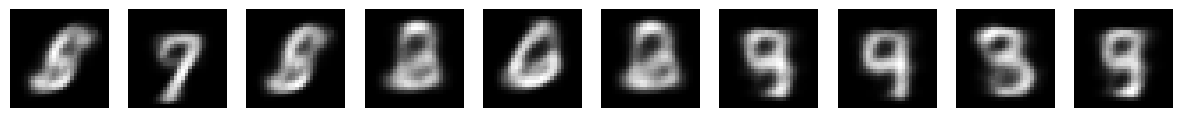

VAE-MLP Epoch [15/50], Loss: 151.26862083333333

##################################################
VAE-MLP Epoch [20/50], Loss: 147.12438020833332
Sample Images:


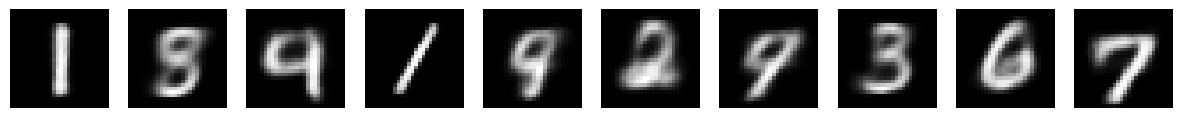

VAE-MLP Epoch [25/50], Loss: 144.56200611979168

##################################################
VAE-MLP Epoch [30/50], Loss: 142.80355377604167
Sample Images:


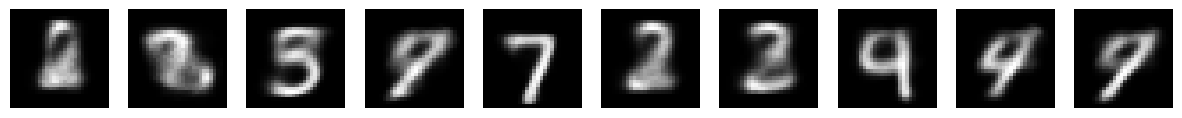

VAE-MLP Epoch [35/50], Loss: 141.552883984375

##################################################
VAE-MLP Epoch [40/50], Loss: 140.75979466145833
Sample Images:


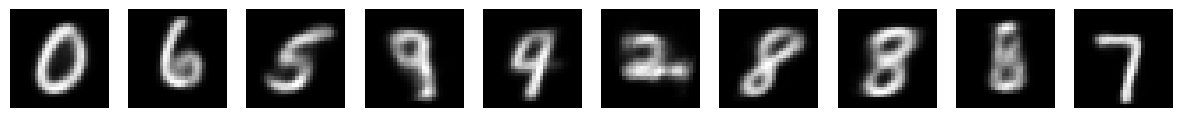

VAE-MLP Epoch [45/50], Loss: 140.072932421875

##################################################
VAE-MLP Epoch [50/50], Loss: 139.194027734375
Sample Images:


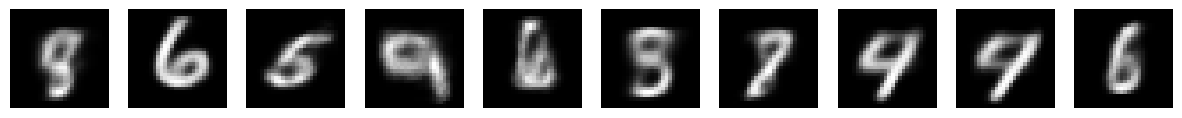

Best model saved as 'best_vae_mlp_model.pth'


In [71]:
# Train VAE-MLP
latent_dim = 2
vae_mlp = VAE_MLP(784, [512,256,64], latent_dim)
train_vae_mlp(vae_mlp, train_loader, num_epochs=50, learning_rate=0.001, latent_dim=latent_dim)

# 2) CVAE --> MLP

In [72]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU()
            
        )

        # Latent space layers
        self.fc_mu = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_class = nn.Linear(hidden_dim[2], num_classes)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()  # Sigmoid activation for the output to represent probabilities
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(x)

        # Latent space
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Concatenate z and y before passing them to the decoder
        zy = torch.cat([z, y], dim=1)

        # Decoder
        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits

In [73]:
# Define CVAE loss function

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, 784)

    # Reconstruction Loss (binary cross-entropy for image data)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-Entropy Loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total Loss (sum of reconstruction, KL divergence, and cross-entropy losses)
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [74]:
# Training Loop - CVAE (MLP)

def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3, latent_dim=2):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):

        if (100 * (epoch+1) / num_epochs) % 20 == 0:
            print()
            print(50 * "#")

        total_loss = 0
        for _, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            labels = labels.to(device)
            # One-hot encode the labels
            num_classes = 10  # Assuming 10 classes (adjust as needed)
            labels_one_hot = F.one_hot(labels, num_classes).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        if (100 * (epoch+1) / num_epochs) % 20 == 0:
            print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (100 * (epoch+1) / num_epochs) % 20 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, latent_dim).to(device)

                # Concatenate the random samples and one-hot encoded class labels before passing them to the decoder
                labels_one_hot = torch.eye(num_classes).to(device)

                sample = torch.cat([z, labels_one_hot], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [10/50], Loss: 138.53287591145832
Sample Images:


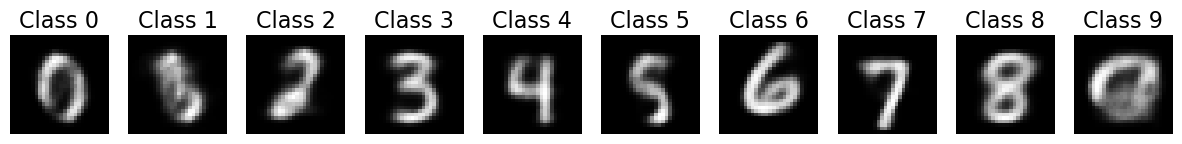


##################################################
CVAE-MLP Epoch [20/50], Loss: 132.60681236979167
Sample Images:


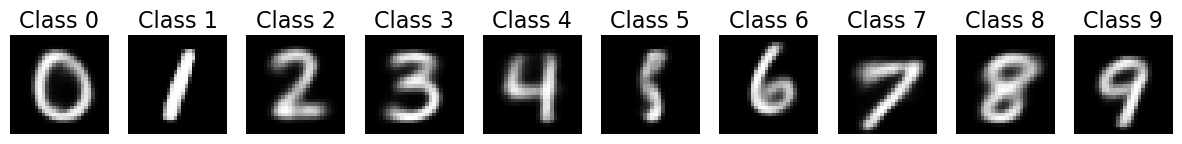


##################################################
CVAE-MLP Epoch [30/50], Loss: 130.25922760416665
Sample Images:


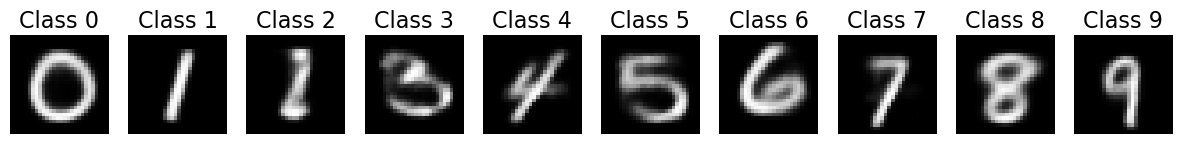


##################################################
CVAE-MLP Epoch [40/50], Loss: 128.835391796875
Sample Images:


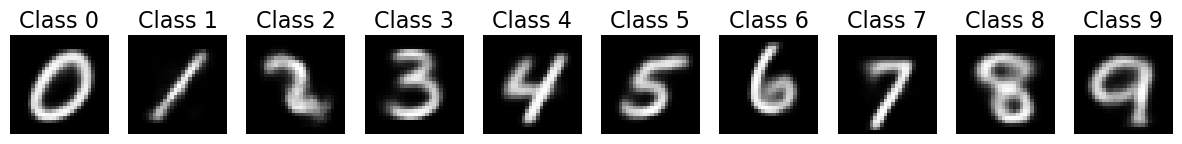


##################################################
CVAE-MLP Epoch [50/50], Loss: 127.82694036458334
Sample Images:


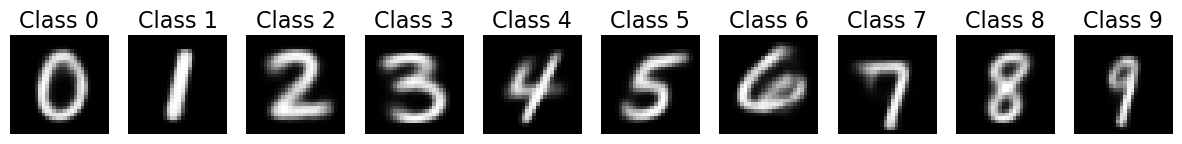

Best model saved as 'best_cvae_mlp_model.pth'


In [75]:
latent_dim = 2
num_classes = 10

cvae_mlp = CVAE_MLP(784, [512,256,64], latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader, num_epochs=50, learning_rate=0.001, latent_dim=latent_dim)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


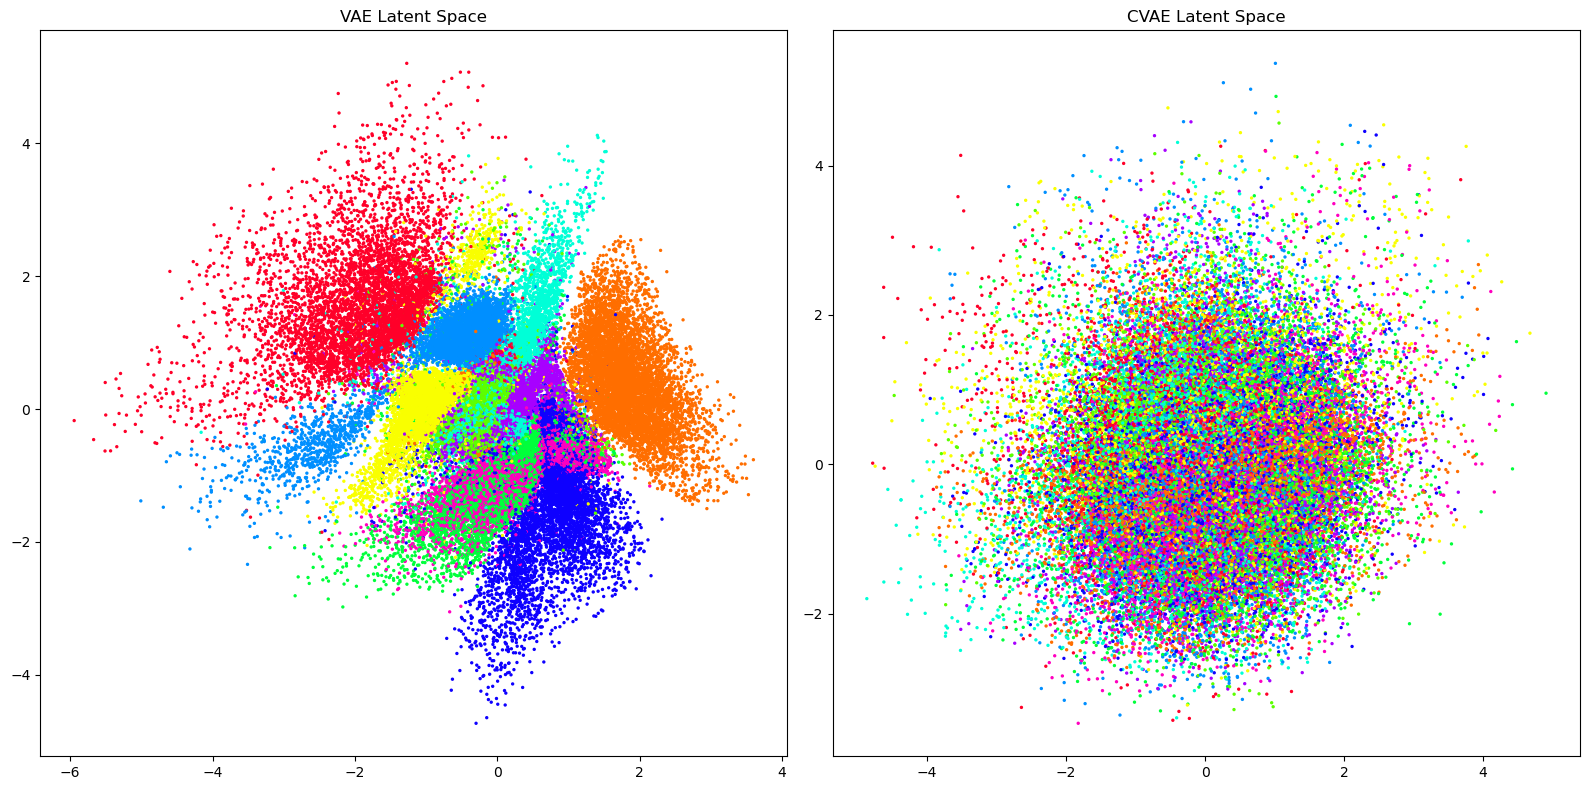

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_mlp = vae_mlp.to(device)
cvae_mlp = cvae_mlp.to(device)

train_loader = DataLoader(train_dataset, batch_size=5120, shuffle=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Set titles for each subplot
axs[0].set_title('VAE Latent Space')
axs[1].set_title('CVAE Latent Space')

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        # One-hot encode the labels
        num_classes = 10
        labels_one_hot = F.one_hot(labels, num_classes).float()

        # Forward pass through the model and calculate the loss using cvae_loss
        _, mu, _, _ = cvae_mlp(data, labels_one_hot)
        _, mu2, _ = vae_mlp(data)
        mu, mu2, labels = mu.cpu(), mu2.cpu(), labels.cpu()
        axs[1].scatter(mu[:, 0], mu[:, 1], s=2, c=labels, cmap='gist_rainbow')
        axs[0].scatter(mu2[:, 0], mu2[:, 1], s=2, c=labels, cmap='gist_rainbow')

    plt.tight_layout()
    plt.show()